In [1]:
%%capture
!pip install stellargraph
!pip install tensorflow-tpu
!pip install tensorflow-addons

In [2]:
import networkx as nx
import random
import pandas as pd
import numpy as np

from stellargraph import StellarGraph
import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from sklearn import model_selection
from stellargraph import datasets
from stellargraph.data import BiasedRandomWalk

from gensim.models import Word2Vec

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

import tensorflow as tf

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import stellargraph as sg
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report



import os

import glob
import hashlib


from tqdm import tqdm
from joblib import Parallel, delayed

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

**Data Generation**<br>
We start by generating The artificial Dataset, containing a total of 2500 Graphs generated by the Albert Barabasi and Watts Strogatz algorithms.

In [3]:

g_list=[]
for iteration in range(1250):
    g_list1=[]
    n = random.randint(30,50)
    m = random.randint(2,n-1)


    g1 = nx.barabasi_albert_graph(n,m)

    G1 = StellarGraph.from_networkx(g1)   
    
    g_list1.append(G1)
    g_list1.append(1)
    g_list.append(g_list1)

for iteration1 in range(1250):
    g_list2=[]
    n = random.randint(10,30)
    m = random.randint(2,n-1)
    p = random.random()
    
    g2= nx.watts_strogatz_graph(n,m,p)

    G2 = StellarGraph.from_networkx(g2)   
    g_list2.append(G2)
    g_list2.append(2)
    g_list.append(g_list2)
    
random.shuffle(g_list)    


In [4]:
graphs=[]
graphs_labels = []
for e in g_list:
    graphs.append(e[0])
    graphs_labels.append(e[1])

In [5]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,2500.0,2500.0
mean,30.0,196.9
std,11.7,148.3
min,10.0,10.0
25%,20.0,68.0
50%,30.0,168.0
75%,40.0,294.0
max,50.0,624.0


**Node2Vec** <br>
node2vec is an algorithmic framework for representational learning on graphs. Given any graph, it can learn continuous feature representations for the nodes, which can then be used for various downstream machine learning <br>
It introduces a 2 step representation learning algorithm :<br>

1. Use second-order random walks to generate sentences from a graph. A sentence is a list of node ids. The set of all sentences makes a corpus.

2. The corpus is then used to learn an embedding vector for each node in the graph. 



The second order random walk implementation  is provided by stellargraph


In [6]:
def randomwalk (G):

  rw = BiasedRandomWalk(G)

  walks = rw.run(nodes=list(G.nodes()), length=50,n=10,p=0.5,q=2.0 )
  return walks  

We use the Word2Vec implementation in the free Python library gensim , to learn representations for each node in the graph.<br>
We retrieve the Word2Vec node embeddings that are 128-dimensional vectors and then we project them down to 2 dimensions using the t-SNE algorithm.

In [7]:

def _2d_embed(walks):

  str_walks = [[str(n) for n in walk] for walk in walks]
  model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)
  transform = TSNE  
  trans = transform(n_components=2)
  node_embeddings = (model.wv.vectors)
  node_embeddings_2d = trans.fit_transform(node_embeddings)
  return node_embeddings_2d


We use the 2d projections of the embeddings to generate an histogram representation for each graph that will be the input of the CNN

In [8]:
def get_hist_node2vec(emb):
    Hs = []
    for i in range(0,2,2):
        H, xedges, yedges = np.histogram2d(x=emb[:,i],y=emb[:,i+1], normed=False)
        Hs.append(H)
    Hs = np.array(Hs)  
      
    return  Hs[0]

In [9]:
walks=[]
for G in graphs:
  walks.append(randomwalk(G))

In [10]:
%%capture
_2d_embeddings=[]
for W in walks:
  _2d_embeddings.append(_2d_embed(W))

In [11]:
_histo=[]
for e in _2d_embeddings:
  _histo.append(get_hist_node2vec(e))

In [12]:
train_histo = _histo[:700]
test_histo = _histo[700:]

train_labels = graphs_labels[:700]
test_labels = graphs_labels[700:]

In [13]:
x_train = np.stack(train_histo)
x_test = np.stack(test_histo)

In [104]:
y_test_list=[]
y_train_list=[]
for e in train_labels:
  if e == 1:
    y_train_list.append(np.array([0]))
  elif e == 2:
    y_train_list.append(np.array([1]))


for e in test_labels:
  if e == 1:
    y_test_list.append(np.array([0]))
  elif e == 2:
    y_test_list.append(np.array([1]))

In [154]:
y_train = np.vstack(y_train_list)
y_test = np.vstack(y_test_list)

In [142]:
# y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
# y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [144]:
y_train[:5]

array([[0.],
       [1.],
       [1.],
       [0.],
       [0.]], dtype=float32)

In [155]:
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [156]:
y_train

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [242]:
del model

**Model Creation**

In [243]:
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3,padding='same',activation='relu',input_shape =[10,10]))
model.add(Conv1D(filters=8, kernel_size=3,padding='same',activation='relu'))
model.add(MaxPool1D(pool_size=2, strides=1,padding='same'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=8,activation='relu'))
model.add(Dense(units=2,activation='sigmoid'))

**Training**

In [244]:
model.compile(optimizer='adam',loss=categorical_crossentropy,metrics=[CategoricalAccuracy(),Precision(),Recall(),F1Score(2)])

In [245]:
History=model.fit(x_train,y_train, batch_size=500, epochs=25, verbose=1,validation_data=(x_test, y_test))

Epoch 1/25
2/2 [==============================] - 2s 522ms/step - loss: 0.8540 - categorical_accuracy: 0.4971 - precision_28: 0.4984 - recall_28: 0.4500 - f1_score: 0.3395 - val_loss: 0.7531 - val_categorical_accuracy: 0.5006 - val_precision_28: 0.5056 - val_recall_28: 0.5000 - val_f1_score: 0.3336
Epoch 2/25
2/2 [==============================] - 0s 52ms/step - loss: 0.7992 - categorical_accuracy: 0.4986 - precision_28: 0.5052 - recall_28: 0.4157 - f1_score: 0.3519 - val_loss: 0.7197 - val_categorical_accuracy: 0.5011 - val_precision_28: 0.5147 - val_recall_28: 0.4961 - val_f1_score: 0.3348
Epoch 3/25
2/2 [==============================] - 0s 59ms/step - loss: 0.7596 - categorical_accuracy: 0.4971 - precision_28: 0.4880 - recall_28: 0.3786 - f1_score: 0.3600 - val_loss: 0.6960 - val_categorical_accuracy: 0.5067 - val_precision_28: 0.5230 - val_recall_28: 0.4800 - val_f1_score: 0.3470
Epoch 4/25
2/2 [==============================] - 0s 100ms/step - loss: 0.7286 - categorical_accuracy:

**Evaluation**

In [246]:
 test_metrics = model.evaluate(x_test,y_test)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
  if name == "f1_score":
    print("       ",name,': ',val)
  else:
    print("\t{}: {:0.4f}".format(name, val))


57/57 [==============================] - 0s 2ms/step - loss: 0.5467 - categorical_accuracy: 0.7450 - precision_28: 0.8305 - recall_28: 0.4844 - f1_score: 0.7284

Test Set Metrics:
	loss: 0.5467
	categorical_accuracy: 0.7450
	precision_28: 0.8305
	recall_28: 0.4844
        f1_score :  [0.79554576 0.6612546 ]


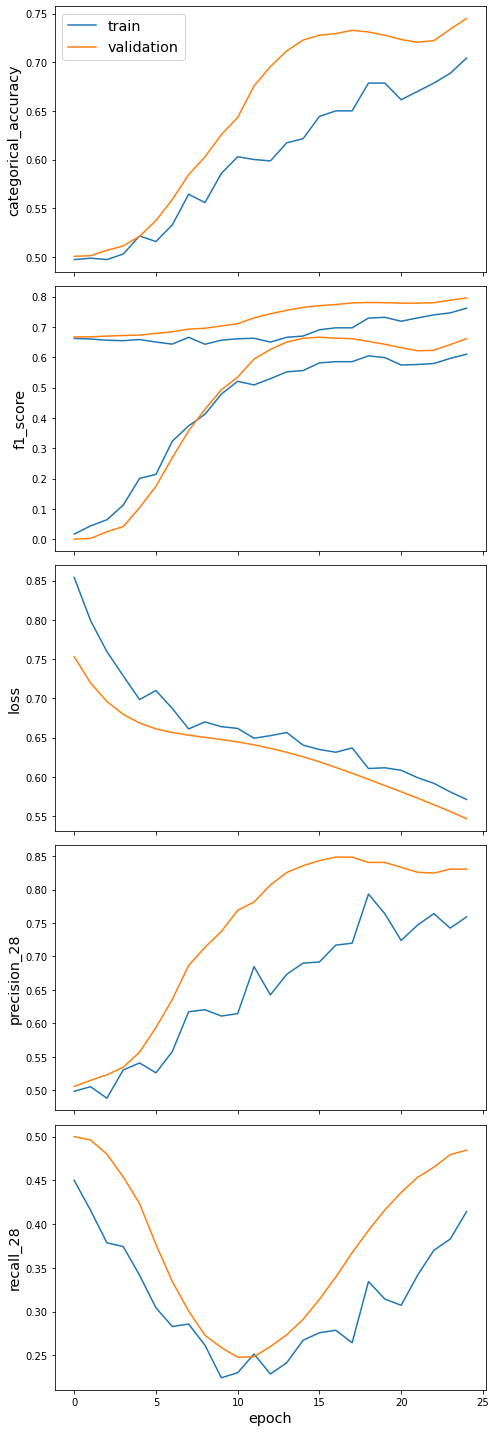

In [247]:
sg.utils.plot_history(History)

In [248]:

y_pred = model.predict(x_test, batch_size=50, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test1 = np.vstack(y_test_list)
print(classification_report(y_test1, y_pred_bool))

36/36 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.66      0.99      0.80       901
           1       0.98      0.50      0.66       899

    accuracy                           0.74      1800
   macro avg       0.82      0.74      0.73      1800
weighted avg       0.82      0.74      0.73      1800



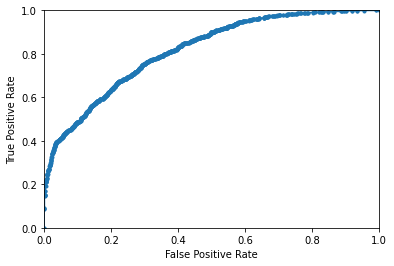

In [249]:
y_pred = model.predict(x_test).ravel()
y_test_roc = np.asarray(y_test).astype('float32').reshape((-1,1))
nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test_roc, y_pred)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)
# plt.plot(nn_fpr_keras,nn_tpr_keras) 
plt.axis([0,1,0,1]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show()    